In [ ]:
import scanpy as sc
from SpatioFreq import SpatioFreq
# dataset = 'Human_Lymph_Node'
import pandas as pd
import numpy as np
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.image import imread
import os
import sys
import torch
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

## read ST data

In [ ]:
adata = sc.read_h5ad('/data/GraphST-main/Data/DCIS1/spatial_DCIS1.h5ad')
adata.var_names_make_unique()

In [ ]:
# preprocessing for ST data
SpatioFreq.preprocess(adata,n_top_genes=3000)
# build graph
SpatioFreq.construct_interaction(adata)
SpatioFreq.add_contrastive_label(adata)

## read scRNA data

In [ ]:
# read scRNA data
file_path = '/data/GraphST-main/Data/DCIS1/sc_RNA_DCIS1.h5ad' # Please replace 'file_path' with the scRNA download path.
adata_sc = sc.read(file_path)
adata_sc.var_names_make_unique()

In [5]:
# preprocessing for scRNA data
SpatioFreq.preprocess(adata_sc,n_top_genes=3000)

##  find overlap genes

In [6]:
# find overlap genes
from SpatioFreq.preprocess import filter_with_overlap_gene
adata, adata_sc = filter_with_overlap_gene(adata, adata_sc)

Number of overlap genes: 1247


/data/SpatioFreq-main/SpatioFreq/preprocess.py:34: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["overlap_genes"] = genes
/data/SpatioFreq-main/SpatioFreq/preprocess.py:35: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata_sc.uns["overlap_genes"] = genes


In [7]:
# get features
SpatioFreq.get_feature(adata,deconvolution=True)

In [ ]:
model = SpatioFreq.SpatioFreq(adata, adata_sc, epochs=1200, random_seed=50, device=device, deconvolution=True,use_frequency_features=False)
adata, adata_sc = model.train_map()

Using random seed: 50
Begin to train ST data...


100%|██████████| 1200/1200 [00:21<00:00, 56.47it/s]


Optimization finished for ST data!
Begin to train scRNA data...


100%|██████████| 1200/1200 [00:03<00:00, 351.77it/s]


Optimization finished for cell representation learning!
Begin to learn mapping matrix...


100%|██████████| 1200/1200 [00:07<00:00, 160.69it/s]

Mapping matrix learning finished!


In [ ]:
adata_sc.obs.rename(columns={'CellType': 'celltype'}, inplace=True)

In [ ]:
# Project cells into spatial space
from SpatioFreq.utils import project_cell_to_spot
project_cell_to_spot(adata, adata_sc, retain_percent=0.15)

,B cell,EndoVas,Epithelial1,Epithelial2,Epithelial3,Fibroblast,Myeloid,NK/T,pDC
AAACATTTCCCGGATT-1,0.000000,0.000000,0.309734,0.000000,0.690266,0.000000,0.000000,0.000000,0.000000
AAACCGGGTAGGTACC-1,0.000000,0.000000,0.505677,0.000000,0.494323,0.000000,0.000000,0.000000,0.000000
AAACCGTTCGTCCAGG-1,0.177679,0.020500,0.000000,0.644637,0.000000,0.127572,0.015945,0.011389,0.002278
AAACCTAAGCAGCCGG-1,0.000000,0.000000,0.323415,0.000000,0.676585,0.000000,0.000000,0.000000,0.000000
AAACGAAGAACATACC-1,0.000000,0.000000,0.419111,0.000000,0.580889,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
TTGTTAGCAAATTCGA-1,0.209566,0.009111,0.000000,0.006834,0.000000,0.127574,0.000000,0.646914,0.000000
TTGTTCAGTGTGCTAC-1,0.075162,0.082058,0.000000,0.047849,0.000000,0.127561,0.259666,0.394037,0.013667
TTGTTGTGTGTCAAGA-1,0.225513,0.000000,0.132116,0.006834,0.403195,0.000000,0.000000,0.232343,0.000000
TTGTTTCACATCCAGG-1,0.000000,0.000000,0.530741,0.000000,0.469259,0.000000,0.000000,0.000000,0.000000


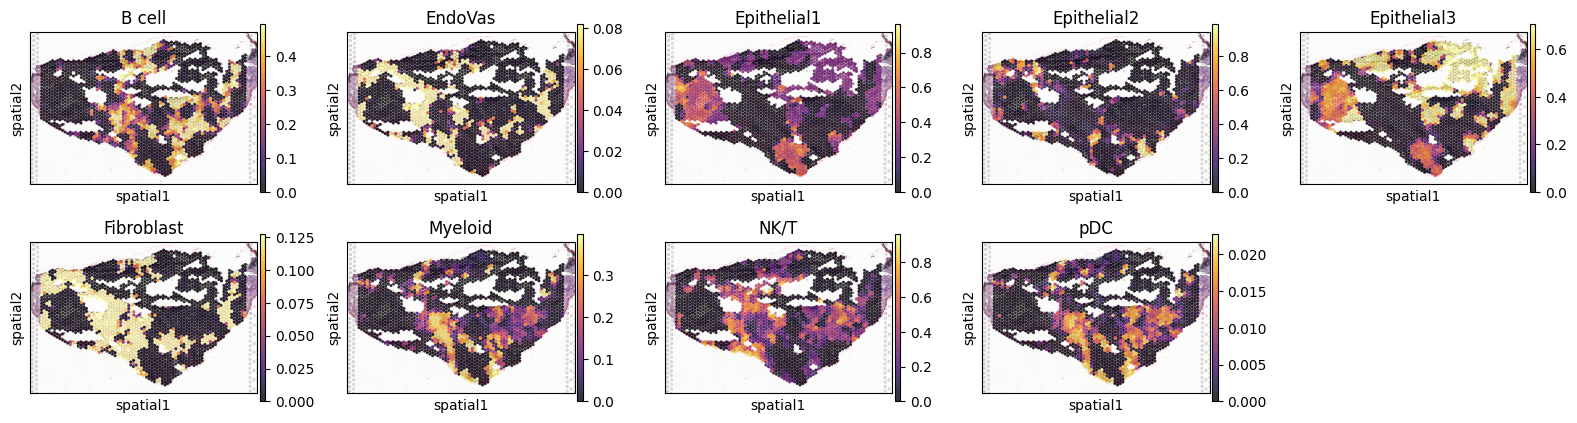

In [ ]:
with mpl.rc_context({'figure.figsize': [3, 2.3]}):
    axes = sc.pl.spatial(
        adata,
        cmap='inferno', 
        color=['B cell', 'EndoVas', 'Epithelial1', 'Epithelial2', 'Epithelial3', 'Fibroblast', 'Myeloid', 'NK/T', 'pDC'],
        ncols=5,
        size=1.5,
        img_key='hires',
        alpha=0.8,       
        alpha_img=0.8,    
        show=False  
    )
    plt.subplots_adjust(hspace=1) 
    plt.show()
